In [1]:
'''
Author: RyanWan
Last Edited: 2020/6/21
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.cm import ScalarMappable
%matplotlib inline

In [2]:
df = pd.read_csv('true_car_listings.csv')
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


In [3]:
states = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona',
        'CA': 'California','CO': 'Colorado','CT': 'Connecticut',
        'DC': 'District of Columbia','DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia','GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana',
        'KS': 'Kansas','KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana',
        'NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York',
        'OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon',
        'PA': 'Pennsylvania','PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina','SD': 'South Dakota',
        'TN': 'Tennessee','TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont',
        'WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
}

In [4]:
df['State'] = df['State'].str.upper() #將洲名轉為大寫
df['State'] = df['State'].str.strip() #去除空格
df['State'] = df['State'].map(states) #將洲的縮寫轉為全名
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,Texas,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,New York,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,Texas,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,Colorado,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,Utah,19UDE2F32GA001284,Acura,ILXAutomatic


In [5]:
group_state= df.groupby('State')
counts =pd.DataFrame(group_state.count()) #Get counts of total cars
average =pd.DataFrame(group_state.mean()) #Get average data(price, mileage)
df2 =pd.DataFrame(data = [counts['Model'],average['Price'],average['Mileage']]).T #T = Transpose
df2.columns = ['Count','Price_Avg','Mileage_Avg']
df2 = df2.drop('District of Columbia') #移除District of Columbia

In [6]:
car_count = df2['Count'].to_dict()
price = df2['Price_Avg'].to_dict()
Mileage = df2['Mileage_Avg'].to_dict()

In [7]:
def create_map(data, title = ''):
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    ax = plt.gca() 
    fig = plt.gcf()
    shp_info = m.readshapefile('st99_d00','states',drawbounds=True)
    colors={}
    statenames=[]
    cmap = plt.cm.jet #地圖色調
    vmin = min(data.values()); vmax = max(data.values())#將數據標準化為0~1區間
    norm = Normalize(vmin=vmin, vmax=vmax)
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    nodata_color = 'black'

    for shapedict in m.states_info:
        
        statename = shapedict['NAME']
        if statename in data:
            data_statename = data[statename]
            colors[statename] = mapper.to_rgba(data_statename)
            statenames.append(statename)
        else:
            statenames.append(statename)
            colors[statename] = nodata_color

    for nshape,seg in enumerate(m.states):
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        if (colors[statenames[nshape]] == nodata_color):
            p_no = poly
        ax.add_patch(poly)
    plt.title(title)

    #bounds = [0, 20000, 40000, 80000, 100000]

    cax = fig.add_axes([0.16, 0.05, 0.7, 0.05]) # x-pos, y-pos, bar-length(x-dir), bar-height(y-dir)
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.set_label('Data Source: https://www.kaggle.com/jpayne/852k-used-car-listings')
    plt.show()

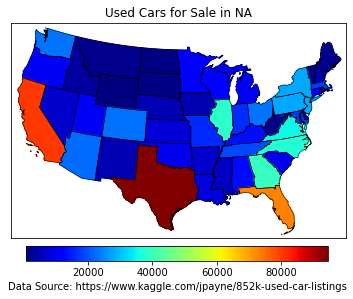

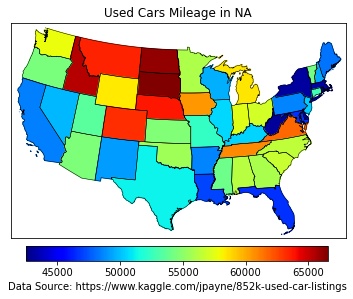

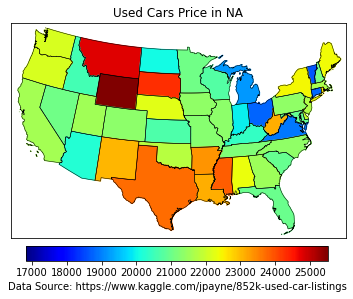

In [8]:
images = [create_map(car_count, title='Used Cars for Sale in NA'), create_map(Mileage, title='Used Cars Mileage in NA'),create_map(price, title='Used Cars Price in NA') ]

In [9]:
#接下來對單一車款做價格預測，這邊先找出二手車總數最多的品牌再從中選出一款(或是從數據內找出數量對多的車款)
maker_list = df['Make'].unique() #type:array
maker_count = len(maker_list) #總車廠數
model_list = df['Model'].unique() 
model_count = len(model_list) #總車款數
maker_car_count = df['Make'].value_counts()
print('總共{}家車廠，共{}種車款在二手市場上'.format(maker_count,model_count))
maker_car_count.head(5)#依數量找出前五家車廠

總共58家車廠，共2736種車款在二手市場上


Ford         110432
Chevrolet    102268
Toyota        77786
Nissan        66250
Honda         50193
Name: Make, dtype: int64

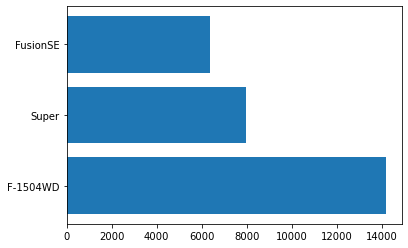

In [10]:
#不同車廠的車款排行
def maker_model_count(df,maker,index=3):
    df1 = df[df['Make'] == str(maker)] 
    model_count = df1.Model.value_counts()
    y_label = model_count.head(index).index
    plt.barh(y_label, model_count.head(index))
    #return(df)
maker_model_count(df,'Ford')

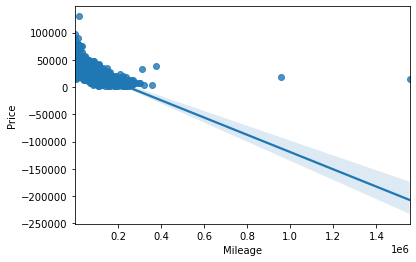

In [11]:
df1 = df[df['Model'] == 'F-1504WD'] #選擇數量最多的車款當作預測目標
#df1 = df1[df['State'] == 'Texas']
#df1 = df1[df1['Price'] < 60000]
sns.regplot('Mileage', 'Price', data=df1) 

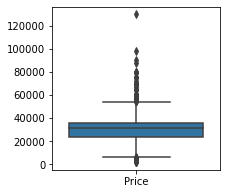

In [12]:
#藉由箱型圖找出Price的離群值
#
df1.describe()
df_price = pd.DataFrame(df1['Price'])
f,ax=plt.subplots(figsize=(3,3))
sns.boxplot(data=df_price,ax=ax)
plt.show()

In [13]:
#超出上、下界即為離群值
Percentile = np.percentile(df1['Price'],[0,25,50,75,100])
IQR = Percentile[3] - Percentile[1]
price_upper_limit = Percentile[3] + IQR * 1.5
price_lower_limit = Percentile[1] - IQR * 1.5
print('上界={}；下界={}'.format((price_upper_limit),(price_lower_limit)))

上界=54122.5；下界=5782.5


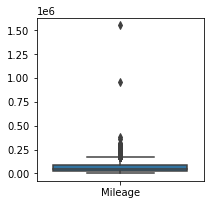

In [14]:
#藉由箱型圖找出Mileage的離群值
df_mileage = pd.DataFrame(df1['Mileage'])
f,ax=plt.subplots(figsize=(3,3))
sns.boxplot(data=df_mileage,ax=ax)
plt.show()

In [15]:
Percentile = np.percentile(df1['Mileage'],[0,25,50,75,100])
IQR = Percentile[3] - Percentile[1]
mileage_upper_limit = Percentile[3] + IQR * 1.5
mileage_lower_limit = Percentile[1] - IQR * 1.5
print(Percentile[1])
print(IQR)
print('上界={}；下界={}'.format((mileage_upper_limit),(mileage_lower_limit)))

27000.0
57523.0
上界=170807.5；下界=-59284.5


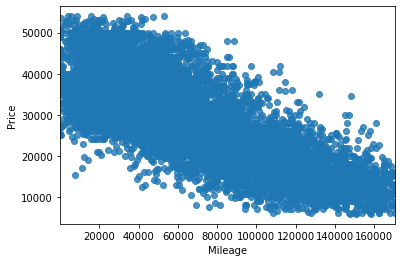

In [16]:
df1 = df1[df1['Price'] < price_upper_limit]
df1 = df1[df1['Price'] > price_lower_limit]
df1 = df1[df1['Mileage'] < mileage_upper_limit] #里程數不會出現負值，不需理會下界
sns.regplot('Mileage', 'Price', data=df1) #里程數與價格呈現反比

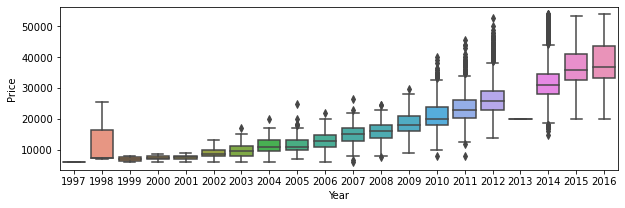

In [17]:
#討論出廠年份對價格的影響
#sns.regplot('Year', 'Price', data=df1)
plt.subplots(figsize=(10,3))
sns.boxplot(x="Year", y="Price", data=df1)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import metrics

In [19]:
#以多元線性迴歸預測價格
def linear_regression(x,y):
    #
    #Data Splitting
    x_train,x_test, y_train, y_test = train_test_split(x, y, random_state=1)
    '''
    確認矩陣尺寸
    print (x_train.shape)
    print (y_train.shape)
    print (x_test.shape)
    print (y_test.shape)
    '''
    #Set Model 
    regr = LinearRegression()
    model=regr.fit(x_train, y_train)
    '''
    變數x需為特徵矩陣，因變數y為向量。

    因此x可以是DataFrame，y可以是Series
    '''
    #Model Output
    print (model)
    print (regr.intercept_)
    print (regr.coef_)
    print(x.columns)

    #Predict
    y_pred = regr.predict(x_test)
    r2_score = metrics.r2_score(y_test,y_pred)
    print('r2_socre=%.4f' %(r2_score))
    
    #RMS 
    sum_err = 0
    for i in range(len(y_pred)):
        sum_err += (y_pred[i]-y_test[i])**2
    rms = np.sqrt(sum_err/len(y_pred)) 
    print('RMS=%.3f' %rms)
    
    return(y_pred, y_test)

In [20]:
def price_plot(y_pred, y_test, n=100):
    plt.figure()
    plt.plot(range(len(y_pred[:n])),y_pred[:n],'b',label="predict")
    plt.plot(range(len(y_pred[:n])),y_test[:n],'r',label="test")
    plt.legend() 
    plt.xlabel("Predict used-car price")
    plt.ylabel('Price')
    plt.show()

LinearRegression()
[-3407343.26109387]
[[ 1.70996746e+03 -8.42894289e-02]]
Index(['Year', 'Mileage'], dtype='object')
r2_socre=0.7031
RMS=5202.060


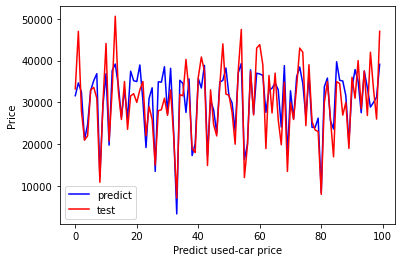

In [21]:
df2 = pd.DataFrame([df1['Year'],df1['Mileage']]).T
y_pred, y_test = linear_regression(x=df2,y=df1['Price'].values.reshape(len(df1['Price']),1))
price_plot(y_pred, y_test, 100)
#平均而言，預測價格會與實際價格落差5202美元

In [45]:
#將洲加入預測模型的變數x
df3 = df1
states_dict = dict(enumerate(states.values()))
states_dict = dict([val, key] for key, val in states_dict.items()) #將洲名轉換成連續變數
df3 = pd.DataFrame([df3['Year'],df3['Mileage'],df3['State'].map(states_dict)]).T
df3.head()

,Year,Mileage,State
267925,2008,113332,33
268873,2008,7777,10
269523,2016,12375,10
270730,2007,81251,45
272283,2005,74963,13


LinearRegression()
[-3408986.37684947]
[[ 1.71072503e+03 -8.42146186e-02  3.84989765e-03]]
Index(['Year', 'Mileage', 'State'], dtype='object')
r2_socre=0.7031
RMS=5201.652


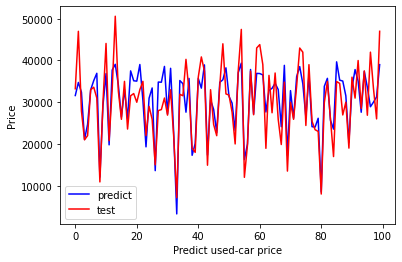

In [44]:
y_pred, y_test = linear_regression(x=df3, y=df1['Price'].values.reshape(len(df1['Price']),1))
price_plot(y_pred, y_test)
#將洲加入模型並沒有增加精準度

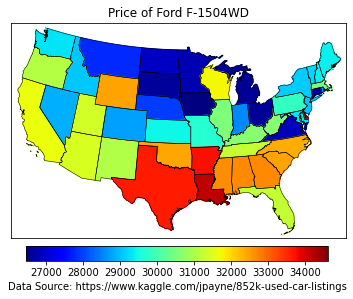

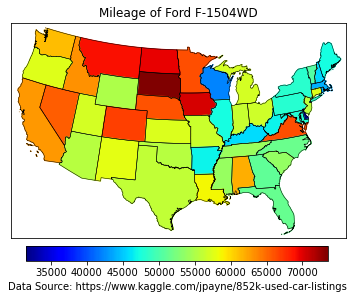

In [31]:
#Ford F-1504WD在各州的平均修售價格
group_by_state= df1.groupby('State')
group_mean = group_by_state.mean()
create_map(group_mean['Price'].to_dict(), title='Price of Ford F-1504WD')
create_map(group_mean['Mileage'].to_dict(), title='Mileage of Ford F-1504WD')

In [33]:
import scipy.stats as ss

In [39]:
def normal_test(data):
    statistic, p_value = ss.normaltest(data)
    plt.hist(data)
    print('P_value = %.3f' % p_value)

P_value = 0.000


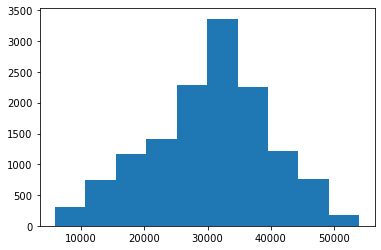

In [41]:
normal_test(df1['Price']) #P-value < 0.5 非常態分佈

P_value = 0.000


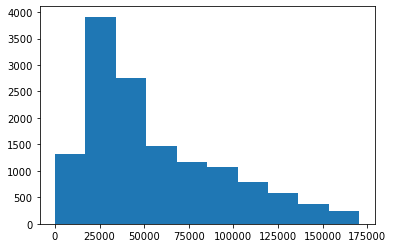

In [42]:
normal_test(df1['Mileage']) #P-value < 0.5 非常態分佈